# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to **import** any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. The dataset is given as .npz file, and will contain data in  numpy array. 

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. You are allowed to use the numpy library to calculate eigen values. All other functions for reconstruction, clustering, etc., should be written from scratch.

12. Change the name of the file with your roll no.



In [1]:
# Cell type : CodeRead

import numpy as np
import matplotlib.pyplot as plt


**Cell type : TextRead**

# Problem 5: Life in Lower Dimensions

You are provided with a dataset of 1797 images - each image is 8x8 pixels and provided as a feature vector of length 64. You will try your hands at transforming this dataset to a lower-dimensional space using PCA, and perform K-means clustering the images in this reduced space.
 




In [2]:
# Cell type : CodeWrite
# write the function for PCA and K-means clustering here. 
    
class PCA:
    
    def __init__(self, whiten = False):
        self.whiten_ = whiten
        
    def fit(self, X):
        '''
        Function to perform PCA on the given data points and learn the eigenvalues and eigenvectors
        '''
        # m : no of datapoints
        self.m_ = X.shape[0]
        # number of dimensions of the data point
        self.dim_ = X.shape[1]
        self.trainX_ = X
        
        # Mean subtraction
        self.mean_ = np.mean(X, axis = 0).reshape((1,-1))
        X_transformed = X - self.mean_
        
        self.whiten_inverse_ = np.identity(self.dim_)
        # Dividing by standard deviation if whitening is needed
        if self.whiten_:
            std = np.std(X_transformed, axis = 0)
            if np.sum(std < 1e-10) > 0:
                # If any standard deviation is zero, dividing by zero cause NaN, hence cancelling whiten trasnform 
                print('[from PCA.fit()] Cancelling normalizing the points as some standard deviations are zero!!')
                self.whiten_ = False
            else:
                np.fill_diagonal(self.whiten_inverse_, std)
                std = std.reshape((1,-1))
                X_transformed = X_transformed / std
            
        self.trainX_transformed_ = X_transformed
        
        self.cov_ = 1/self.m_ * (X_transformed.T @ X_transformed)
        eigen_values , eigen_vectors = np.linalg.eigh(self.cov_)

        # np.linalg.eigh returns eigenvalues in ascending order, hence reversing
        self.variances_ = eigen_values[::-1]
        self.components_ = eigen_vectors[:,::-1]
    
    def transform(self, X = None, no_components = None):
        '''
        Function to return the representation of the given points in new space with reduced dimensions
        If X == None, the training data will be used
        If no_components == None, all the components will be chosen to represent the point
        '''
        if X is None:
            X = self.trainX_transformed_ 
        else:
            # Reshaping as a 2D matrix to avoid undesired results while multiplying
            if X.ndim == 1:
                X = X.reshape((1, X.shape[0]))
            X = X - np.mean(X, axis = 0).reshape((1,-1))
            if self.whiten_:
                X = X / np.std(X, axis = 0).reshape((1,-1))

        assert(X.ndim == 2 and X.shape[1] == self.dim_)
        
        if no_components is None:
            no_components = self.dim_

        # Chossing the top reqd no of eigenvectors to represent the data in lower dimensions
        eigenvectors_subset = self.components_[:, :no_components]

        # Corrdinates in new axes
        return X @ eigenvectors_subset
    
    def reconstruct(self, X = None, no_components = None):
        '''
        Function to reconstruct the input using given number of components alone
        If X == None, the training data will be used
        If no_components == None, all the components will be chosen to reconstruct the point
        '''
        mean = self.mean_
        whiten_inv = self.whiten_inverse_
        if X is not None:
            mean = np.mean(X, axis = 0).reshape((1,-1))
            np.fill_diagonal(whiten_inv, np.std(X, axis = 0))
            
        X_reduced = self.transform(X, no_components)
        no_components = X_reduced.shape[1]
        
        # Chossing the top reqd no of eigenvectors to represent the data in lower dimensions
        eigenvectors_subset = self.components_[:, :no_components]

        # The vector reconstructed using the (most important) given no of components alone
        return (X_reduced @ eigenvectors_subset.T) @ whiten_inv + mean
    
    def proportion_variance_explained(self, component = None):
        '''
        Function to return the variance ratio of data along a particular component
        If component == None, all the variances will be returned
        ''' 
        if component is None:
            return self.variances_ / np.sum(self.variances_)
        return self.variances_[component] / np.sum(self.variances_)
    

    
class K_Means:
    
    def __init__(self, n_clusters=2, max_iters=100):
        self.n_clusters_ = n_clusters
        self.max_iters_ = max_iters
    
    def dist(self, x, y):
        '''
        Function to calculate distance between two vectors (we use euclidean distance for this problem)
        '''
        return np.linalg.norm(x-y)
    
    def dist_sq(self, x, y):
        '''
        Function to calculate square distance between two vectors (we use euclidean distance for this problem)
        '''
        return np.sum((x-y)**2)
        
        
    def fit(self, X):
        '''
        Function to perform K-means clustering algorithm on the given datapoints and learn the centroids
        '''
        # m : no of datapoints
        self.m_ = X.shape[0]
        # number of dimensions of the data point
        self.dim_ = X.shape[1]
        
        self.trainX_ = X
        # Stores all the centroids of clusters
        self.centroids_ = np.array([X[i] for i in range(self.n_clusters_)])
        
        self.assignments_ = np.zeros((self.n_clusters_, self.m_))

        for iteration in range(self.max_iters_):
            # Storing previous assignments to check convergence and stop training
            prev_assignments = self.assignments_
            # Stores the r_{ij} for this iteration, where r_{ij} = 1 if jth data point is assigned to cluster i, else 0
            self.assignments_ = np.zeros((self.n_clusters_, self.m_))
            
            # E step : assigning closest centroid to the points
            for i, x in enumerate(X):
                distances = np.array([self.dist(x,c) for c in self.centroids_])
                closest_centroid = np.argmin(distances)
                self.assignments_[closest_centroid][i] = 1
                
            prev_centroids = self.centroids_
            
            # M step : making centroids mean of the points assigned to it
            self.centroids_ = (self.assignments_ @ X) / np.sum(self.assignments_, axis = 1).reshape((-1, 1))
            # Setting centroids which are not assigned to any datapoints to previous centroid
            self.centroids_ = np.array([self.centroids_[i] if np.sum(np.isfinite(self.centroids_[i])) == self.dim_ 
                                        else prev_centroids[i] for i in range(self.n_clusters_)])
            
            # Checking for convergence by seeing if the assignments of points to clusters have changed
            optimized = (np.sum(self.assignments_ == prev_assignments) == self.n_clusters_*self.m_)
            if optimized:
                print(f'[from K_Means.fit()] K-means algorithm stopping at {iteration+1}th iteration as convergence is achieved!!')
                break
        
        self.cluster_index_ = np.argmax(self.assignments_, axis = 0)

    def predict(self, X):
        '''
        Function to predict the cluster the given data points belong to
        '''
        if X.ndim == 1:
            X = X.reshape((1, X.shape[0]))
            
        assert(X.ndim == 2 and X.shape[1] == self.dim_)
        
        closest_cluster = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            distances = np.array([self.dist(x,c) for c in self.centroids_])
            closest_cluster[i] = np.argmin(distances)
            
        return closest_cluster
    
    def WSS(self):
        '''
        Function to return the within-cluster sum of squared errors (WSS) for the training data
        '''
        return np.sum([self.dist_sq(self.trainX_[i],self.centroids_[self.cluster_index_[i]]) for i in range(self.m_)])
    
    def _silhouette_A_score(self, ind):
        '''
        Function to calculate A(ind) in silhouette score
        '''
        same_cluster_points = np.where(self.cluster_index_ == self.cluster_index_[ind])[0]
        return np.mean([self.dist(self.trainX_[ind],self.trainX_[j]) for j in same_cluster_points if ind != j])
        
    def _silhouette_B_score(self, ind):
        '''
        Function to calculate B(ind) in silhouette score
        '''
        assigned_cluster_indices = np.unique(self.cluster_index_)
        if assigned_cluster_indices.shape[0] <= 1:
            return 0
        return np.min([np.mean([self.dist(self.trainX_[ind],self.trainX_[j]) for j in np.where(self.cluster_index_ == cluster_ind)[0]]
                              ) for cluster_ind in assigned_cluster_indices if cluster_ind != self.cluster_index_[ind]])
    
    def avg_silhouette_value(self):
        '''
        Function to return the average silhouette value for the training dataset
        '''
        A = np.array([self._silhouette_A_score(i) for i in range(self.m_)])
        B = np.array([self._silhouette_B_score(i) for i in range(self.m_)])
        
        S = (B - A) / np.maximum(A,B)
        
        return np.mean(np.nan_to_num(S))
            

**Cell type : TextRead**

# Problem 5

#### 5a) Run PCA algorithm on the given data-set. Plot the cumulative percentage variance explained by the principal components. Report the number of principal components that contribute to 90% of the variance in the dataset.




Shape of input : (1797, 64)
------------------------------------------------------------
[from PCA.fit()] Cancelling normalizing the points as some standard deviations are zero!!
The first 21 components contribute 90.3199% (> 90%) of the variance


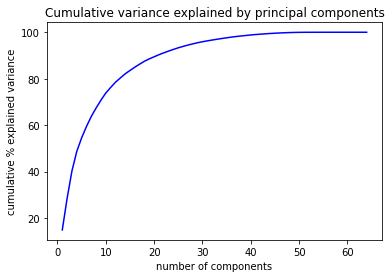

In [3]:
# Cell type : CodeWrite
# write the code for loading the data, running the PCA algorithm, and plotting. 
# (Use the functions written previously.)


def load_data():
    data = np.load('Data/Data.npz')
    return data['arr_0']


def plot_variance(pca):
    cumvar_percentage = np.cumsum(pca.proportion_variance_explained()) * 100
    plt.figure()
    plt.xlabel('number of components')
    plt.ylabel('cumulative % explained variance')
    plt.title('Cumulative variance explained by principal components')
    plt.plot(np.arange(1,65), cumvar_percentage, color='blue', linestyle='solid')
    # plt.savefig('variance.png')
    
    # Getting first index where cumulative varianc eexceed 90%
    first_ind = np.where(cumvar_percentage >= 90)[0][0]
    print(f'The first {first_ind+1} components contribute {cumvar_percentage[first_ind]:.4f}% (> 90%) of the variance')
    
    return cumvar_percentage
    

X = load_data()
print('Shape of input :',X.shape)
print('-' * 60)
pca = PCA(whiten=True)
pca.fit(X)
cum_var = plot_variance(pca)

####5b)  Perform reconstruction of data using the dimensionality-reduced data considering the number of dimensions [2,4,8,16]. Report the Mean Square Error (MSE) between the original data and reconstructed data, and interpret the optimal dimensions $\hat{d}$ based on the MSE values.



The MSE between original data and data reconstructed using 2 components : 858.9448
The MSE between original data and data reconstructed using 4 components : 616.1911
The MSE between original data and data reconstructed using 8 components : 391.7947
The MSE between original data and data reconstructed using 16 components : 180.9397
------------------------------------------------------------
We choose optimal dimensions d_hat as 16
The variance explained by first 16 components is 84.9402%
------------------------------------------------------------
Data matrix in reduced dimensions (N x 16) : 
[[ -1.25946645 -21.27488348   9.46305462 ...  -3.33874935   5.90658968
   -2.74359339]
 [  7.9576113   20.76869896  -4.43950604 ...  -6.51699585  -2.29176445
    2.13402725]
 [  6.99192297   9.95598641  -2.95855808 ...   6.84104002  -1.67969049
    4.27600306]
 ...
 [ 10.8012837    6.96025223  -5.59955453 ...   1.27058987   2.66524033
    5.84545154]
 [ -4.87210009 -12.42395362  10.17086635 ...  -

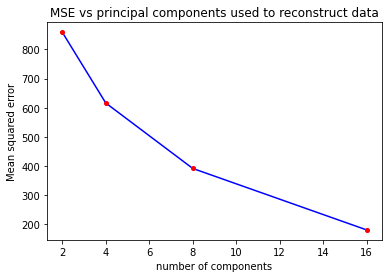

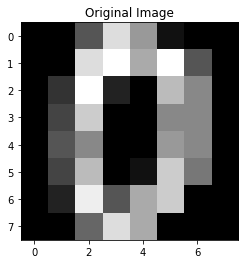

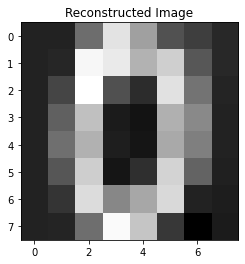

In [4]:
# Cell type : CodeWrite
# Write the code for data reconstruction, run the algorithm for dimensions.

def MSE(X_true, X_pred):
    # Function to calculate mean square error between X_true and X_pred
    assert(X_true.shape == X_pred.shape)
    m = X_true.shape[0]
    return 1/m * np.sum((X_pred - X_true)**2)

def report_mse(pca):
    no_dims = [2,4,8,16]
    X_true = X
    mse_list = []
    for dim in no_dims:
        X_reconstructed = pca.reconstruct(no_components = dim)
        mse = MSE(X_true, X_reconstructed)
        # We can also calculate MSE as sum of the eigenvalues corresponding to the components left out (and get the same answer)
        # mse = np.sum(pca.variances_[dim:])
        mse_list.append(mse)
        print(f'The MSE between original data and data reconstructed using {dim} components : {mse:.4f}')
        
    plt.figure()
    plt.xlabel('number of components')
    plt.ylabel('Mean squared error')
    plt.title('MSE vs principal components used to reconstruct data')
    plt.plot(no_dims, mse_list, color='blue', linestyle='solid', marker='o', markeredgecolor='red', markerfacecolor='red', markersize=4)
    # plt.savefig('mse.png')
    
    return mse_list

mse_list = report_mse(pca)
print('-' * 60)

# The optimal value of d_hat from MSE is 16 as it gives the least MSE value
d_hat = 16
# The variance explained by 16 components is also clost to 85% which is good and re-emphazies out choice of d_hat
print(f'We choose optimal dimensions d_hat as {d_hat}')
print(f'The variance explained by first {d_hat} components is {cum_var[d_hat-1]:.4f}%')
print('-' * 60)

# Uncomment the code between horizontal lines to print the data matrix in reduced dimensions (N x d_hat dimensions)
# ----------------------------------------------------
print(f'Data matrix in reduced dimensions (N x {d_hat}) : ')
print(pca.transform(no_components = 16))
# ----------------------------------------------------

# Plotting the original image
plt.figure()
plt.title('Original Image')
plt.imshow(X[0].reshape((8,8)), cmap='gray')
# plt.savefig('original_image.png')

# Plotting the reconstructed image (using d_hat = 16 principal components)
X_recon = pca.reconstruct(no_components = d_hat)
plt.figure()
plt.title('Reconstructed Image')
plt.imshow(X_recon[0].reshape((8,8)), cmap='gray')
# plt.savefig('reconstructed_image.png')

####5c) Apply K-means clustering on the reduced dataset from last subpart (b) (i.e., the $R^{64}$ to $R^\hat{d}$ reduced dataset; pick the initial k points as cluster centers during initialization). Report the optimal choice of K you have made from the set [1...15]. Which method did you choose to find the optimum number of clusters? And explain briefy why you chose that method. Also, show the 2D scatter plot (consider only the first two dimensions of optimal $\hat{d}$) of the datapoints based on the cluster predicted by K-means (use different color for each cluster).


In [ ]:
# Cell type : CodeWrite
# Write the code for dimensionality reduction, run k-means algorithm on the reduced data-set and do plotting.

def choice_of_K(X, silhouette_needed=False):
    wss_list = []
    silhouette_list = []
    for k in range(1,16):
        kmeans = K_Means(n_clusters=k)
        kmeans.fit(X)
        wss = kmeans.WSS()
        wss_list.append(wss)
        if silhouette_needed and k > 1:
            silhouette = kmeans.avg_silhouette_value()
            silhouette_list.append(silhouette)
        
    
    plt.figure()
    plt.xlabel('number of clusters')
    plt.ylabel('within-cluster sum of squared error')
    plt.title('WSS vs number of clusters')
    plt.plot(np.arange(1,16), wss_list, color='blue', linestyle='solid', marker='x', markeredgecolor='red', markerfacecolor='red', markersize=5)
    # plt.savefig('wss.png')
    
    if silhouette_needed:
        plt.figure()
        plt.xlabel('number of clusters')
        plt.ylabel('average silhouette value')
        plt.title('Average silhouette value vs number of clusters')
        plt.plot(np.arange(2,16), silhouette_list, color='blue', linestyle='solid', marker='x', markeredgecolor='red', markerfacecolor='red', markersize=5)
        # plt.savefig('silhouette.png')
    
    return wss_list, silhouette_list
    
def visualize_clusters(X, n_clusters = 9):
    kmeans = K_Means(n_clusters=n_clusters)
    kmeans.fit(X)
    colors = plt.cm.rainbow(np.linspace(0,1,n_clusters))
    plt.figure(figsize=(7,5))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(f'Visualizing first two dimensions (out of {X.shape[1]}) of the clustered datapoints')
    for i in range(kmeans.n_clusters_):
        points = np.where(kmeans.cluster_index_ == i)[0]
        plt.scatter(kmeans.trainX_[points,0],kmeans.trainX_[points,1],color=colors[i],label=str(i+1),s=20)
    plt.scatter(kmeans.centroids_[:,0],kmeans.centroids_[:,1],color='black',label='centroids',s=50)
    plt.legend(loc='lower left')
    # plt.savefig('kmeans_cluster.png')
 

X_transformed = pca.transform(no_components = d_hat)

# Uncomment the code between horizontal lines to plot the WSS vs no of clusters plot alone
# ----------------------------------------------------
# wss_list, _ = choice_of_K(X_transformed)
# ----------------------------------------------------

# Uncomment the code between horizontal lines to plot both WSS and silhouette score vs no of clusters plot
# NOTE !!! silhouette score takes quite some time to run
# ----------------------------------------------------
wss_list, silhoeutte_list = choice_of_K(X_transformed, silhouette_needed=True)
# ----------------------------------------------------

# An optimal choice of K seems to be 9 as that is where the elbow of WSS occurs
#                                               (and the maximum average silhouette value at that point further confirms it)
visualize_clusters(X_transformed, 9)

# Uncomment the code between horizontal lines to visualize clusters for data reduced to 2 dimensions using PCA
# ----------------------------------------------------
X_tr = pca.transform(no_components = 2)
visualize_clusters(X_tr, 9)
# ----------------------------------------------------


[from K_Means.fit()] K-means algorithm stopping at 2th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 17th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 21th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 37th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 16th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 15th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 20th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 20th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 23th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 13th iteration as convergence is achieved!!
[from K_Means.fit()] K-means algorithm stopping at 

####5d) In the next TextWrite cell, Summarise and explain your observations from the above experiments. Is the PCA+K-means clustering consistent with how your brain would cluster the images?



**Cell type : TextWrite**

Report your observations, MSE values and the method used to choose the optimal number of clusters.


## MSE values

The MSE between original data and data reconstructed :
- using 2 components : 858.9448
- using 4 components : 616.1911
- using 8 components : 391.7947
- using 16 components : 180.9397


## Observations (MSE)

- We expect the MSE to decrease (and the explained variance to increase) monotonically as number of components used to reconstruct the data is increased, and that is exactly what the MSE plot and the explained variance plot also display. Also, the rate of decrease in MSE (or increase in explained variance) slows down as number of components is increased as in evident from the plots. All this can be explained by noting that the variance explained by representing data using $M$ components (out of $D$ components) is :
$$
\sum_{i=1}^M \lambda_i
$$
and the MSE for the case is :
$$
\sum_{i=M+1}^D \lambda_i
$$
where $\lambda_i$ for $i = 1,2,\cdots,D$ are the eigenvalues of $S = \frac{1}{N} X^T X$ sorted in non-increasing order. The MSE is monotonically decreasing (and explained variance increasing) with number of principal components becasue all eigenvalues of $S$ are positive, since it is a positive semi-definite matrix. Alse, the rate of decrease in MSE (or increase in explained variance) becomes slower because the eigenvalues that occur later are smaller in magnitude.
- Out of the list $[2,4,8,16]$ given, we choose $\hat{d} = 16$, since it has the least MSE of 180.9397 and a variance explained of 84.9402% (close to 85%), hence retaining the individuality of the data to a good extent and reconstructing original data without much loss. We can observe this by comparing one sample from the original and corresponding reconstructed image and notice how closely the reconstructed one resembles the original.


## Method to choose the optimal number of clusters

We choose the optimal value of $K$ (number of clusters) as **9**.

For choosing optimal value of $K$, we calculate the **WSS** (within-cluster sum of square error), which is the sum of squared error of each point from it's predicted cluster center for different values of $K$ and plot it. It is basically the objective function (distortion measure) that we maximize through the iterative algorithm in K-Means clustering. We choose the the elbow point (where the plot bends from high slope to low slope region) as the optimal value for $K$. The intuition behind this is as follows:
- The WSS will clearly reduce with increase in $K$ as the model with more number of clusters can perform as good as the one with lesser number of clusters by simply not assigning certain clusters to any points. 
- But having more number of clusters makes it harder to analyse or observe patterns in the data.
- Just after the elbow point, after which the WSS starts reducing very slowly, we get diminished returns which is not worth the additional cost, almost similar to over-fitting.

Though we can see that the elbow point occurs at $K = 9$ from the WSS plot, it is not very obvious, as there seems to be quite a few number of choices. To re-emphasize and verify the most optimal choice of $K$ we then plot the **average silhouette value** for all the datapoints. The silhouette value is a measure of how similar a point is to its own cluster (cohesion) compared to other clusters (separation) and it ranges from $-1$ to $+1$. A high silhouette value indicates that the point is well matched to its own cluster and poorly matched to neighboring clusters.

From the silhouette value plot, it is clear that the maximum value (peak) occurs at $K = 9$, which helps us to zero in on the elbow point and also serves as a sanity check to the choice.


## Observations (K-Means)

- We have set a default maximum number of iterations the K-Means will run to 100 and defined convergence as achieved when the $r_{i}^{(n)}$ matrix (storing $1$ when $x^{(i)}$ is assigned to cluster with centroid $m^{(n)}$), doesn't change after the E-step and M-step. We however observe that the K-Means algorithm took much lesser iterations than 100 to converge (maximum being 37, on an average about 20), assuring the quickness of the algorithm.
- The only possibility where randomness can creep in during PCA+K-Means is during sorting of eigenvalues when the eigenvectors corresponding to equal eigenvalues can be placed in any order (the centroid initialisations are fixed). But np.linalg.eigh() which returns the eigenvalues (and corresponding eigenvectors) in non-decreasing order seems to do it in a deterministic way, as there was no change in the metric values or scores or even the clustering scatter plot, how many ever times I ran the program. Hence, as a whole there is no randomness involved, and therefore exists slight possibility that the clustering is unable to come out of a local minima solution if stuck there.


## Comments on PCA+K-Means

We can see in the figure above the K-Means clustering for the points reduced to $\hat{d} = 16$ dimensions using PCA. The plot however does not seem to match what we would have done/expected manually, as K-Means is known to form convex clusters. This is because we only visualize the first 2 dimensions out of the 16 dimensions, hence the clusters which seem to overlap in 2-dimensions may actually be separated out when considered the other dimensions. 

However, to confirm that the K-Means algorithm is indeed working correctly, we reduce the datapoints to 2 dimensions using PCA, and plot the result of K-Means clustering again. This time we see that the clustering exactly matches what we have in mind and gives us convex sets as one would expect.